In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import pickle
import requests
import time
from datasets import load_dataset

d:\programs\anaconda3\envs\ait\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [3]:
from torchvision.utils import draw_bounding_boxes

In [4]:
ds = load_dataset("keremberke/license-plate-object-detection", name="full")


Found cached dataset license-plate-object-detection (C:/Users/pczum/.cache/huggingface/datasets/keremberke___license-plate-object-detection/full/1.0.0/e7740c5ed939eb2184b6f17aee84b3a304e2f46f093835a839bcf19f0ca38ce4)
100%|██████████| 3/3 [00:00<00:00, 97.59it/s]


In [5]:
x = ds['train']['image']
y = [x['bbox'] for x in ds['train']['objects']]
width = ds['train']['width']
height = ds['train']['height']


In [6]:
ignore_list = []
for i in range(len(y)):
    if len(y[i]) != 1:
        ignore_list.append(i)

In [7]:
#remove ignore list from data
y = [y[i] for i in range(len(y)) if i not in ignore_list]
x = [x[i] for i in range(len(x)) if i not in ignore_list]
width = [width[i] for i in range(len(width)) if i not in ignore_list]
height = [height[i] for i in range(len(height)) if i not in ignore_list]

In [8]:
ymin = []
xmin = []
ymax = []
xmax = []
for i in range(len(y)):
    xmin.append(y[i][0][1] / height[i])
    ymin.append(y[i][0][0] / width[i])
    xmax.append(y[i][0][3] / height[i] + xmin[i])
    ymax.append(y[i][0][2] / width[i] + ymin[i])

In [9]:
#create dataframe for training
df = pd.DataFrame()
df['image'] = x
df['xmin'] = xmin
df['ymin'] = ymin
df['xmax'] = xmax
df['ymax'] = ymax

#set type to float32
df['xmin'] = df['xmin'].astype(np.float32)
df['ymin'] = df['ymin'].astype(np.float32)
df['xmax'] = df['xmax'].astype(np.float32)
df['ymax'] = df['ymax'].astype(np.float32)


In [10]:
#show df columns
df.columns

Index(['image', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

In [11]:
#df head without image
df.drop(columns=['image']).head()

,xmin,ymin,xmax,ymax
0,0.770833,0.179688,0.853333,0.308437
1,0.503906,0.767578,0.571406,0.842578
2,0.383602,0.846680,0.423641,0.908529
3,0.714730,0.388672,0.739979,0.494297
4,0.862573,0.255859,0.883172,0.313359


In [12]:
def show_img(index):
    img = df['image'][index]
    width, height = img.size
    box = [[df['xmin'][index], df['ymin'][index], df['xmax'][index], df['ymax'][index]]]
    #get width and height
    width, height = img.size
    img = np.array(img)
    #to tensor
    img = tf.convert_to_tensor(img)
    #expand dims
    img = tf.expand_dims(img, axis=0)
    #convert to float
    img = tf.cast(img, dtype=tf.float32)
    #normalize
    img = img/255.0
    #convert to relative coordinates for plotting 
    print(box)
    box = tf.expand_dims(box, axis=0)
    box = tf.cast(box, dtype=tf.float32)

    i = tf.image.draw_bounding_boxes(img, box, [[1.0, 0.0, 0.0]]*len(box))
    plt.imshow(i[0])

[[0.7708333, 0.1796875, 0.85333335, 0.3084375]]


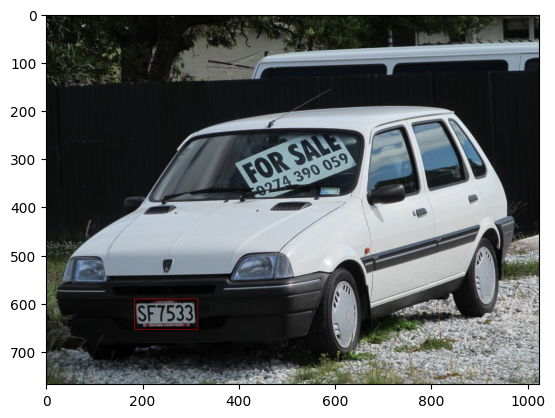

In [13]:
show_img(0)

In [14]:
#split data into train and test
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)


## Define the model

In [15]:
WIDTH = 400
HEIGHT = 400
CHANNEL = 3

In [16]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

In [17]:
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss="mse")

In [18]:
def get_batch(df, i, size=32):
    x_images = df['image'][i*size:(i+1)*size]
    y_batch_train = df.drop(columns=['image'])[i*size:(i+1)*size]

    #place images in batch tensor
    x_batch_train = tf.zeros((0, HEIGHT, WIDTH, CHANNEL))
    for img in x_images:
        img = img.resize((WIDTH, HEIGHT))
        img = np.array(img)
        img = tf.convert_to_tensor(img)
        img = tf.cast(img, dtype=tf.float32)
        img = img/255.0
        x_batch_train = tf.concat([x_batch_train, tf.expand_dims(img, axis=0)], axis=0)
    return x_batch_train, y_batch_train

In [19]:
epochs = 10
batch_size = 16
train_steps = len(train_df) // batch_size
test_steps = len(test_df) // batch_size
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = Adam(learning_rate=0.0005)

best_loss = 1000000

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    # get batch of training data
    train_losses = []
    test_losses = []
    # Iterate over the batches of the dataset.
    for step in range(train_steps):
        # get batch of training data
        x_batch_train, y_batch_train = get_batch(train_df, step, batch_size)
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_losses.append(float(loss_value))
    
    for step in range(test_steps):
        # get batch of training data
        x_batch_test, y_batch_test = get_batch(test_df, step, batch_size)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_test, training=False)

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_test, logits)

        test_losses.append(float(loss_value))
    if np.mean(test_losses) < best_loss:
        best_loss = np.mean(test_losses)
        model.save("model.h5")
        print("Model saved")
    #early stopping
    print("Average losses at epoch {}: Train: {:.4f} Test: {:.4f}".format(epoch, np.mean(train_losses), np.mean(test_losses)))
    if epoch > 5 and np.mean(test_losses) > best_loss:
        break


Start of epoch 0
Model saved
Average losses at epoch 0: Train: 0.1103 Test: 0.1082

Start of epoch 1
Model saved
Average losses at epoch 1: Train: 0.0786 Test: 0.0053

Start of epoch 2
Model saved
Average losses at epoch 2: Train: 0.0028 Test: 0.0027

Start of epoch 3
Average losses at epoch 3: Train: 0.0016 Test: 0.0032

Start of epoch 4
Model saved
Average losses at epoch 4: Train: 0.0013 Test: 0.0025

Start of epoch 5
Average losses at epoch 5: Train: 0.0013 Test: 0.0041

Start of epoch 6
Average losses at epoch 6: Train: 0.0014 Test: 0.0038


In [20]:
best_model = tf.keras.models.load_model("model.h5")

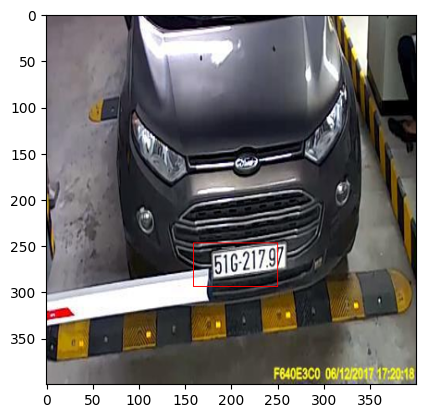

In [21]:
img, realbox = get_batch(test_df, 100, 1)
box = best_model(img)
box = tf.expand_dims(box, axis=0)
output = tf.image.draw_bounding_boxes(img, box, [[1.0, 0.0, 0.0]]*len(box))
plt.imshow(output[0])

[[0.82186115 0.4610582  0.8961448  0.70262563]]


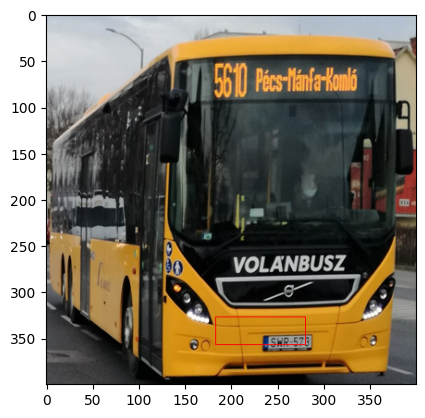

In [171]:
#load random image from folder
files = os.listdir("./data/images_new/")
img = Image.open("./data/images_new/" + random.choice(files))

img = img.resize((WIDTH, HEIGHT))

img = np.array(img)
img = tf.convert_to_tensor(img)
img = tf.cast(img, dtype=tf.float32)
img = img/255.0
img = tf.expand_dims(img, axis=0)

box = best_model(img)
#increase size of box by 10%
box = box.numpy()
print(box)
box[0][0] = box[0][0]
box[0][1] = box[0][1]
box[0][2] = box[0][2]
box[0][3] = box[0][3]
box = tf.expand_dims(box, axis=0)

output = tf.image.draw_bounding_boxes(img, box, [[1.0, 0.0, 0.0]]*len(box))
plt.imshow(output[0])